# Breakout Strategy

ロングとショートが反転するタイミングをとらえて売買を行う戦略をとった場合のリターンを、日経255の過去データを使用してシミュレーションします。ロングとショートの反転のタイミングを5日、10日、20日の枠で評価したそれぞれの場合について、戦略のリターンを表kあします。

### Load Packages

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import scipy.stats
#from colour import Color
import plotly as py
import plotly.graph_objs as go
import plotly.offline as offline_py
from colour import Color

color_scheme = {
    'index': '#B6B2CF',
    'etf': '#2D3ECF',
    'tracking_error': '#6F91DE',
    'df_header': 'silver',
    'df_value': 'white',
    'df_line': 'silver',
    'heatmap_colorscale': [(0, '#6F91DE'), (0.5, 'grey'), (1, 'red')],
    'background_label': '#9dbdd5',
    'low_value': '#B6B2CF',
    'high_value': '#2D3ECF',
    'y_axis_2_text_color': 'grey',
    'shadow': 'rgba(0, 0, 0, 0.75)',
    'major_line': '#2D3ECF',
    'minor_line': '#B6B2CF',
    'main_line': 'black'}


def generate_config():
    return {'showLink': False, 'displayModeBar': False, 'showAxisRangeEntryBoxes': True}

def _generate_stock_trace(prices):
    return go.Scatter(
        name='Index',
        x=prices.index,
        y=prices,
        line={'color': color_scheme['main_line']})

def _generate_buy_annotations(prices, signal):
    return [{
        'x': index, 'y': price, 'text': 'Long', 'bgcolor': color_scheme['background_label'],
        'ayref': 'y', 'ax': 0, 'ay': 20}
        for index, price in prices[signal == 1].iteritems()]


def _generate_sell_annotations(prices, signal):
    return [{
        'x': index, 'y': price, 'text': 'Short', 'bgcolor': color_scheme['background_label'],
        'ayref': 'y', 'ax': 0, 'ay': 160}
        for index, price in prices[signal == -1].iteritems()]

def plot_high_low(prices, lookback_high, lookback_low, title):
    config = generate_config()
    layout = go.Layout(title=title)

    stock_trace = _generate_stock_trace(prices)
    high_trace = go.Scatter(
        x=lookback_high.index,
        y=lookback_high,
        name='Column lookback_high',
        line={'color': color_scheme['major_line']})
    low_trace = go.Scatter(
        x=lookback_low.index,
        y=lookback_low,
        name='Column lookback_low',
        line={'color': color_scheme['minor_line']})

    offline_py.iplot({'data': [stock_trace, high_trace, low_trace], 'layout': layout}, config=config)

def plot_signal(price, signal, title):
    config = generate_config()
    buy_annotations = _generate_buy_annotations(price, signal)
    sell_annotations = _generate_sell_annotations(price, signal)
    layout = go.Layout(
        title=title,
        annotations=buy_annotations + sell_annotations)

    stock_trace = _generate_stock_trace(price)

    offline_py.iplot({'data': [stock_trace], 'layout': layout}, config=config)

def plot_lookahead_prices(prices, lookahead_price_list, title):
    config = generate_config()
    layout = go.Layout(title=title)
    colors = Color(color_scheme['low_value'])\
        .range_to(Color(color_scheme['high_value']), len(lookahead_price_list))

    traces = [_generate_stock_trace(prices)]
    for (lookahead_prices, lookahead_days), color in zip(lookahead_price_list, colors):
        traces.append(
            go.Scatter(
                x=lookahead_prices.index,
                y=lookahead_prices,
                name='{} Day Lookahead'.format(lookahead_days),
                line={'color': str(color)}))

    offline_py.iplot({'data': traces, 'layout': layout}, config=config)

def plot_price_returns(prices, lookahead_returns_list, title):
    config = generate_config()
    layout = go.Layout(
        title=title,
        yaxis2={
            'title': 'Returns',
            'titlefont': {'color': color_scheme['y_axis_2_text_color']},
            'tickfont': {'color': color_scheme['y_axis_2_text_color']},
            'overlaying': 'y',
            'side': 'right'})
    colors = Color(color_scheme['low_value'])\
        .range_to(Color(color_scheme['high_value']), len(lookahead_returns_list))

    traces = [_generate_stock_trace(prices)]
    for (lookahead_returns, lookahead_days), color in zip(lookahead_returns_list, colors):
        traces.append(
            go.Scatter(
                x=lookahead_returns.index,
                y=lookahead_returns,
                name='{} Day Lookahead'.format(lookahead_days),
                line={'color': str(color)},
                yaxis='y2'))

    offline_py.iplot({'data': traces, 'layout': layout}, config=config)

def plot_signal_returns(prices, signal_return_list, titles):
    config = generate_config()
    layout = go.Layout(
        yaxis2={
            'title': 'Signal Returns',
            'titlefont': {'color': color_scheme['y_axis_2_text_color']},
            'tickfont': {'color': color_scheme['y_axis_2_text_color']},
            'overlaying': 'y',
            'side': 'right'})
    colors = Color(color_scheme['low_value'])\
        .range_to(Color(color_scheme['high_value']), len(signal_return_list))

    stock_trace = _generate_stock_trace(prices)
    for (signal_return, signal, lookahead_days), color, title in zip(signal_return_list, colors, titles):
        non_zero_signals = signal_return[signal_return != 0]
        signal_return_trace = go.Scatter(
                x=non_zero_signals.index,
                y=non_zero_signals,
                name='{} Day Lookahead'.format(lookahead_days),
                line={'color': str(color)},
                yaxis='y2')

        buy_annotations = _generate_buy_annotations(prices, signal)
        sell_annotations = _generate_sell_annotations(prices, signal)
        layout['title'] = title
        layout['annotations'] = buy_annotations + sell_annotations

        offline_py.iplot({'data': [stock_trace, signal_return_trace], 'layout': layout}, config=config)


def plot_signal_histograms(signal_list, title, subplot_titles):
    assert len(signal_list) == len(subplot_titles)

    signal_series_list = [signal.stack() for signal in signal_list]
    all_values = pd.concat(signal_series_list)
    x_range = [all_values.min(), all_values.max()]
    y_range = [0, 1500]
    config = generate_config()
    colors = Color(color_scheme['low_value']).range_to(Color(color_scheme['high_value']), len(signal_series_list))

    fig = py.tools.make_subplots(rows=1, cols=len(signal_series_list), subplot_titles=subplot_titles, print_grid=False)
    fig['layout'].update(title=title, showlegend=False)

    for series_i, (signal_series, color) in enumerate(zip(signal_series_list, colors), 1):
        filtered_series = signal_series[signal_series != 0].dropna()
        trace = go.Histogram(x=filtered_series, marker={'color': str(color)})
        fig.append_trace(trace, 1, series_i)
        fig['layout']['xaxis{}'.format(series_i)].update(range=x_range)
        fig['layout']['yaxis{}'.format(series_i)].update(range=y_range)

    offline_py.iplot(fig, config=config)


def plot_signal_to_normal_histograms(signal_list, title, subplot_titles):
    assert len(signal_list) == len(subplot_titles)

    signal_series_list = [signal.stack() for signal in signal_list]
    all_values = pd.concat(signal_series_list)
    x_range = [all_values.min(), all_values.max()]
    y_range = [0, 1500]
    config = generate_config()

    fig = py.tools.make_subplots(rows=1, cols=len(signal_series_list), subplot_titles=subplot_titles, print_grid=False)
    fig['layout'].update(title=title)

    for series_i, signal_series in enumerate(signal_series_list, 1):
        filtered_series = signal_series[signal_series != 0].dropna()
        filtered_series_trace = go.Histogram(
            x=filtered_series,
            marker={'color': color_scheme['low_value']},
            name='Signal Return Distribution',
            showlegend=False)
        normal_trace = go.Histogram(
            x=np.random.normal(np.mean(filtered_series), np.std(filtered_series), len(filtered_series)),
            marker={'color': color_scheme['shadow']},
            name='Normal Distribution',
            showlegend=False)
        fig.append_trace(filtered_series_trace, 1, series_i)
        fig.append_trace(normal_trace, 1, series_i)
        fig['layout']['xaxis{}'.format(series_i)].update(range=x_range)
        fig['layout']['yaxis{}'.format(series_i)].update(range=y_range)

    # Show legened
    fig['data'][0]['showlegend'] = True
    fig['data'][1]['showlegend'] = True

    offline_py.iplot(fig, config=config)

## Market Data
### Load Data
実際のデータを使用すると実践的な経験が得られますが、1つのプロジェクトにまとめようとしているすべてのトピックを網羅しているわけではありません。 新しい株を作成することでこれを解決します。 [Terbium]（https://en.wikipedia.org/wiki/Terbium）を採掘している企業が莫大な利益を上げているシナリオを作成しました。 市場のこのセクターのすべての会社が構成されています。 これらは、このプロジェクトの後半でデモンストレーションに使用される、大きな成長を遂げているセクターを表しています。 

In [3]:
%%time
nikkei255 = pd.read_csv('../nikkei255.csv', index_col=0)
path = os.path.join(os.environ['CSVDIR'] ,'daily')
print(path)

li_close = []
li_high = []
li_low = []

for code, company in tqdm(nikkei255.iterrows()):
    # load CSV files
    df_each_close = pd.read_csv(os.path.join(path, str(code) + '.csv'), usecols=['date', 'close'])
    df_each_high  = pd.read_csv(os.path.join(path, str(code) + '.csv'), usecols=['date', 'high'])
    df_each_low   = pd.read_csv(os.path.join(path, str(code) + '.csv'), usecols=['date', 'low'])

    # Set date time index
    df_each_close['date'] = pd.to_datetime(df_each_close['date'])
    df_each_close = df_each_close.set_index('date')
    df_each_high['date'] = pd.to_datetime(df_each_high['date'])
    df_each_high = df_each_high.set_index('date')
    df_each_low['date'] = pd.to_datetime(df_each_low['date'])
    df_each_low = df_each_low.set_index('date')

    # Set compnay name to each columns
    df_each_close = df_each_close.rename(columns={'close': company['name']})
    df_each_high = df_each_high.rename(columns={'high': company['name']})
    df_each_low = df_each_low.rename(columns={'low': company['name']})

    li_close.append(df_each_close)
    li_high.append(df_each_high)
    li_low.append(df_each_low)

close = pd.concat(li_close, axis = 1)
high = pd.concat(li_high, axis = 1)
low = pd.concat(li_low, axis = 1)

C:\Users\y509541\git\AITradeJapanStock\Japan Stock\data\daily



Wall time: 6.06 s


### データの可視化
ここで得られたデータは2次元のデータで、close終値を例にとると以下のようなデータが格納されています。

In [4]:
close

,日清製粉グループ本社,明治ホールディングス,日本ハム,サッポロホールディングス,アサヒグループホールディングス,キリンホールディングス,宝ホールディングス,キッコーマン,味の素,ニチレイ,...,電通グループ,Zホールディングス,トレンドマイクロ,サイバーエージェント,楽天,リクルートホールディングス,日本郵政,東宝,セコム,コナミホールディングス
date,,,,,,,,,,,,,,,,,,,,,
2019-01-04,2279.0,8890.0,4220.0,2301.0,4256.0,2309.0,1343.0,5850.0,1934.5,3090.0,...,4575,273.0,5890,1026.25,726.0,2581.0,1265.0,3960.0,9333.0,4750.0
2019-01-07,2295.0,8830.0,4330.0,2369.0,4365.0,2373.0,1356.0,5840.0,1961.5,3125.0,...,4890,281.0,6060,1061.25,765.0,2723.0,1286.0,4170.0,9390.0,4825.0
2019-01-08,2250.0,8740.0,4385.0,2367.0,4325.0,2345.5,1358.0,5700.0,1937.0,3050.0,...,4895,286.0,6130,1060.00,783.0,2744.0,1284.0,4125.0,9446.0,4915.0
2019-01-09,2321.0,9000.0,4435.0,2470.0,4400.0,2407.5,1393.0,6010.0,1948.0,3090.0,...,4885,292.0,6120,1086.25,798.0,2886.0,1302.0,3985.0,9342.0,4980.0
2019-01-10,2279.0,8900.0,4485.0,2440.0,4339.0,2369.5,1354.0,5720.0,1929.5,3080.0,...,4800,291.0,6070,1043.75,809.0,2880.5,1305.0,4070.0,9346.0,4895.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-15,1806.0,6940.0,4975.0,2253.0,4766.0,2053.0,1483.0,6490.0,2189.5,2794.0,...,3485,563.1,5390,1950.00,1376.0,5203.0,939.2,4555.0,9206.0,6680.0
2021-04-16,1803.0,6910.0,4980.0,2264.0,4767.0,2079.5,1493.0,6550.0,2208.5,2782.0,...,3430,566.2,5370,1949.00,1359.0,5114.0,937.1,4735.0,9217.0,6640.0
2021-04-19,1785.0,6850.0,4930.0,2236.0,4717.0,2082.5,1485.0,6580.0,2198.5,2770.0,...,3475,567.7,5470,1991.00,1371.0,5035.0,935.8,4575.0,9169.0,6750.0


### 銘柄の例
終値から1株がどのように見えるか見てみましょう。 この例とこのプロジェクトの今後の表示例では、三井住友フィナンシャルグループの株を使用します。 すべての株をグラフ化しようとすると、情報が多すぎます。 

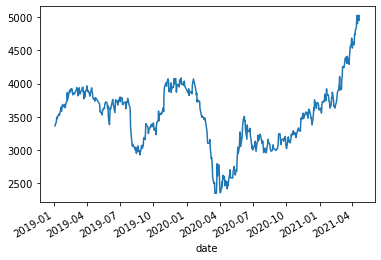

In [5]:
sample_ticker = 'AGC'
close[sample_ticker].plot()

## アルファ・リサーチ プロセス

このプロジェクトでは、「ブレイクアウト」シグナルをコーディングを通じてして検証します。 これらのステップがアルファリサーチ ワークフローのどこに該当するかを理解することが重要です。トレーディングシグナルのS/N比は非常に低いため、ノイズに対する _overfitting_ の罠に陥りがちです。 したがって、シグナルのコーディング実装にいきなり着手することはお勧めできません。 _overfitting_ を緩和するために、一般的な観察と仮説から始めるのが最善です。 つまり、データに触れる _前_ に、次の質問に答えられるはずです。 

> 市場または投資家の行動のどの特徴が、私のシグナルが使用しようとする永続的な異常につながるでしょうか？ 

理想的には、仮説の背後にある仮定は、実際に信号をコーディングして評価する前にテスト可能です。

このプロジェクトでは、「観察と調査」、「仮説の形成」、「仮説の検証」のステップが完了して、コーディングによる実装に入れる段階にあることを前提としています。以下の仮説をもとに進めます。

- ニュースや重要な投資家の取引利益がない場合、株式は一定の範囲で変動します。
- トレーダーは、範囲の上限で売り/ショートし、範囲の下限で買い/カバーすることにより、この範囲に制限された行動を定期的に利用しようとします。 この動作により、範囲の存在が強化されます。
- 重要なニュースリリースや大規模な投資家からの市場圧力などにより、株価が範囲外になった場合：
     - 範囲の境界で流動性を提供してきた流動性トレーダーは、損失を軽減するためにポジションをカバーしようとします。これにより、範囲外への移動が拡大します。
     - 範囲外への移動は、他の投資家の関心を引き付けます。 これらの投資家は、_herding_の行動バイアス（例：[Herd Behavior]（https://www.investopedia.com/university/behavioral_finance/behavioral8.asp））により、トレンドの継続を支持するポジションを構築します。

上記の仮設に基づいてコーディングを進めます..

## 過去数日の高値(high)と安値(low)の算出
ブレイクアウト戦略の指標として、価格の高値(hight)と安値(low)を使用します。 このセクションでは、 `get_high_lows_lookback`を実装して、数日間のウィンドウ(過去lookback_days)で最大高価格と最小低価格を取得します。当日の価格が含まれないようにします。 

In [6]:
def get_high_lows_lookback(high, low, lookback_days):
    """
    Get the highs and lows in a lookback window.
    
    Parameters
    ----------
    high : DataFrame
        High price for each ticker and date
    low : DataFrame
        Low price for each ticker and date
    lookback_days : int
        The number of days to look back
    
    Returns
    -------
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
    """
    lookback_high = high.shift(periods=1, axis=0).rolling(lookback_days).max()
    lookback_low = low.shift(periods=1, axis=0).rolling(lookback_days).min()

    return lookback_high, lookback_low

### データの可視化
`get_high_lows_lookback`の実装を使用して、過去50日間の高値と安値を取得し、それぞれの株価と比較します。 例としてZホールディングスを使用します。 

In [7]:
lookback_days = 50 #過去50日分(当日を含まない)
lookback_high, lookback_low = get_high_lows_lookback(high, low, lookback_days)
plot_high_low(
    close[sample_ticker],
    lookback_high[sample_ticker],
    lookback_low[sample_ticker],
    f'過去{lookback_days}日間の{sample_ticker}の株価の高値と安値')

## ロングとショートの各シグナルの算出
生成された高値と安値のインジケーターを使用して、ブレイクアウト戦略によりロングとショートのシグナルを作成します。 get_long_shortを実装して、次のシグナルを生成します。 

| シグナル | 条件 |
|----|------|
| -1 | Low > Close Price |
| 1  | High < Close Price |
| 0  | 上記以外 |

このチャートでは、**Close**は _close_ パラメータです。 ** Low **および** High **は、 `get_high_lows_lookback`、` lookback_high`および `lookback_low`パラメーターから生成された値です。 

例えば、過去50日の高値より終値が高くなったタイミングをロングのシグナル、逆に安値より終値が低くなったタイミングをショートのシグナルとしています。

In [8]:
def get_long_short(close, lookback_high, lookback_low):
    """
    Generate the signals long, short, and do nothing.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
    
    Returns
    -------
    long_short : DataFrame
        The long, short, and do nothing signals for each ticker and date
    """
    #cf
    #The following link may help you understand various data conversions:
    #Numpy Array types and conversions between types
    #https://stackoverflow.com/questions/15891038/change-column-type-in-pandas
    longSignal  = (lookback_high < close) * 1
    shortSignal = (lookback_low  > close) * -1
    signal = (longSignal+shortSignal).astype('int64')
    
    return signal

### View Data
Let's compare the signals you generated against the close prices. This chart will show a lot of signals. Too many in fact. We'll talk about filtering the redundant signals in the next problem. 

In [9]:
signal = get_long_short(close, lookback_high, lookback_low)
plot_signal(
    close[sample_ticker],
    signal[sample_ticker],
    f'{sample_ticker}ストックのロングとショートシグナル')

## シグナルの絞り込み
上のグラフで多数のシグナルが連続して表示されているのがわかりますた。すでに株をショートしている状況で、株のショートの追加のシグナルがあっても役立ちません。これは、ロングの場合も同様です。

`filter_signals`を実装して、` lookahead_days`内で連続するロングとショートのシグナルを除外します。前のシグナルが同じだった場合は、シグナルを「0（何もしない）」に変更します。たとえば、次のような単一の株式時系列があるとします。 

`[1, 0, 1, 0, 1, 0, -1, -1]`

lookaheadが3日の場合、上記の時系列が以下のように変更されるよう`filter_signals`を実装します。

`[1, 0, 0, 0, 1, 0, -1, 0]`

To help you implement the function, we have provided you with the `clear_signals` function. This will remove all signals within a window after the last signal. For example, say you're using a windows size of 3 with `clear_signals`. It would turn the Series of long signals

最後のシグナルの後のウィンドウ内のすべてのシグナルが削除するのに、`clear_signals`関数を提供しています。たとえば、`clear_signals`でウィンドウサイズ3を使用しているとします。 

`[0, 1, 0, 0, 1, 1, 0, 1, 0]`

は、以下のように変換されます。

`[0, 1, 0, 0, 0, 1, 0, 0, 0]`

`clear_signals`は、同じタイプの一連のシグナルのみを受け取ります。ここで、` 1`はシグナルであり、 `0`はシグナルとなりません。 ロングのシグナルとショートのシグナルを混在させることはできません。 この関数を使用して、 `filter_signals`を実装します。

`filter_signals`を実装するために、ベクトル化されたソリューションを見つけようとすることはお勧めしません。 代わりに、各列で[`iterrows`]（https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.iterrows.html）を使用する必要があります。

In [10]:
def clear_signals(signals, window_size):
    """
    Clear out signals in a Series of just long or short signals.
    
    Remove the number of signals down to 1 within the window size time period.
    
    Parameters
    ----------
    signals : Pandas Series
        The long, short, or do nothing signals
    window_size : int
        The number of days to have a single signal       
    
    Returns
    -------
    signals : Pandas Series
        Signals with the signals removed from the window size
    """
    # Start with buffer of window size
    # This handles the edge case of calculating past_signal in the beginning
    clean_signals = [0]*window_size
    
    for signal_i, current_signal in enumerate(signals):
        # Check if there was a signal in the past window_size of days
        has_past_signal = bool(sum(clean_signals[signal_i:signal_i+window_size]))
        # Use the current signal if there's no past signal, else 0/False
        clean_signals.append(not has_past_signal and current_signal)
        
    # Remove buffer
    clean_signals = clean_signals[window_size:]

    # Return the signals as a Series of Ints
    return pd.Series(np.array(clean_signals).astype(np.int), signals.index)


def filter_signals(signal, lookahead_days):
    """
    Filter out signals in a DataFrame.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    filtered_signal : DataFrame
        The filtered long, short, and do nothing signals for each ticker and date
    """
    longSignal = signal.replace(-1,0)
    for (columnName, columnData) in longSignal.iteritems():
        longSignal[columnName] = clear_signals(columnData,lookahead_days)

    shortSignal = signal.replace(1,0)
    for (columnName, columnData) in shortSignal.iteritems():
        shortSignal[columnName] = clear_signals(columnData,lookahead_days)

    cleared = longSignal + shortSignal
     
    return cleared

### データ可視化
同じチャートを見てみます。上述のように余分なシグナルは除外しています。

In [11]:
signal_5 = filter_signals(signal, 5)
signal_10 = filter_signals(signal, 10)
signal_20 = filter_signals(signal, 20)
for signal_data, signal_days in [(signal_5, 5), (signal_10, 10), (signal_20, 20)]:
    plot_signal(
        close[sample_ticker],
        signal_data[sample_ticker],
        f'{signal_days}日窓の{sample_ticker}ストックのロングとショート')

## 先読み終値
With the trading signal done, we can start working on evaluating how many days to short or long the stocks. In this problem, implement `get_lookahead_prices` to get the close price days ahead in time. You can get the number of days from the variable `lookahead_days`. We'll use the lookahead prices to calculate future returns in another problem.

トレーディングシグナルを得たので、次に、株式をショートまたはロングする日数について求めます。そのために `get_lookahead_prices`を実装して、終値を数日前に取得します。 日数は変数 `lookahead_days`で指定します。先読み価格を使用して、別の問題の将来のリターンを計算します。 

In [12]:
def get_lookahead_prices(close, lookahead_days):
    """
    Get the lookahead prices for `lookahead_days` number of days.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    """
    #TODO: Implement function
    
    return close.shift(periods = -lookahead_days, axis = 0)

### 可視化
`get_lookahead_prices`関数を使用して、5、10、および20日間の先読み終値を生成しましょう。

また、数年ではなく、数か月のサンプル株のサブセクションをグラフ化します。これにより、5日、10日、20日の先読みの違いを確認できます。 それ以外の場合は、ズームアウトされたグラフを見るときにそれらが互いに噛み合います。

In [13]:
lookahead_5 = get_lookahead_prices(close, 5)
lookahead_10 = get_lookahead_prices(close, 10)
lookahead_20 = get_lookahead_prices(close, 20)
plot_lookahead_prices(
    close[sample_ticker].iloc[150:250],
    [
        (lookahead_5[sample_ticker].iloc[150:250], 5),
        (lookahead_10[sample_ticker].iloc[150:250], 10),
        (lookahead_20[sample_ticker].iloc[150:250], 20)],
    f'{sample_ticker}ストックの5, 10, ならびに20日の先読み終値')

## 先読み価格のリターン
`get_return_lookahead`を実装して、終値と先読み価格の間のログ価格リターンを生成します。 

In [14]:
def get_return_lookahead(close, lookahead_prices):
    """
    Calculate the log returns from the lookahead days to the signal day.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    
    Returns
    -------
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    """

    return np.log(lookahead_prices) - np.log(close)

### データ可視化
前の問題と同じ先読み価格とサンプルの株の同じサブセクションを使用して、先読みリターンを表示します。

In [15]:
price_return_5 = get_return_lookahead(close, lookahead_5)
price_return_10 = get_return_lookahead(close, lookahead_10)
price_return_20 = get_return_lookahead(close, lookahead_20)
plot_price_returns(
    close[sample_ticker].iloc[150:250],
    [
        (price_return_5[sample_ticker].iloc[150:250], 5),
        (price_return_10[sample_ticker].iloc[150:250], 10),
        (price_return_20[sample_ticker].iloc[150:250], 20)],
    f'{sample_ticker}ストックの5, 10, ならびに20日の先読みリターン')

## シグナルによるリターンの計算
価格のリターンから、シグナルによるリターンを計算します。

In [16]:
def get_signal_return(signal, lookahead_returns):
    """
    Compute the signal returns.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    
    Returns
    -------
    signal_return : DataFrame
        Signal returns for each ticker and date
    """
    return signal * lookahead_returns

### データ可視化
以前の先読み価格を引き続き使用して、シグナルリターンを表示します。 

In [17]:
title_string = '{} day LookaheadSignal Returns for {} Stock'
signal_return_5 = get_signal_return(signal_5, price_return_5)
signal_return_10 = get_signal_return(signal_10, price_return_10)
signal_return_20 = get_signal_return(signal_20, price_return_20)
plot_signal_returns(
    close[sample_ticker],
    [
        (signal_return_5[sample_ticker], signal_5[sample_ticker], 5),
        (signal_return_10[sample_ticker], signal_10[sample_ticker], 10),
        (signal_return_20[sample_ticker], signal_20[sample_ticker], 20)],
    [title_string.format(5, sample_ticker), title_string.format(10, sample_ticker), title_string.format(20, sample_ticker)])

## 重要度の検証
### ヒストグラム
シグナルによるリターンをヒストグラム表示します。

In [18]:
plot_signal_histograms(
    [signal_return_5, signal_return_10, signal_return_20],
    'Signal Return',
    ('5 Days', '10 Days', '20 Days'))

C:\Users\y509541\AppData\Local\Anaconda3\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



それらの数字は、ほぼ正常に分配されているようです。 しかし、時間枠が拡大するにつれて、以下が増加します
- 外れ値
- 分散

これらに関連して、ヒストグラムに含まれるいくつかのピークである可能性があります。
異常値のために時間ウィンドウ期間が長くなると、リターンを予測することがより困難になります。
より制御された方法でトレーディングを実行するには、外れ値を削除する必要があります。 

## 外れ値
外れ値をより適切に視覚化するために、5、10、および20日のシグナルリターンを、各シグナルリターン分布の平均と偏差が同じである正規分布に比較してみましょう。

In [19]:
plot_signal_to_normal_histograms(
    [signal_return_5, signal_return_10, signal_return_20],
    'Signal Return',
    ('5 Days', '10 Days', '20 Days'))

## Kolmogorov-Smirnovテスト
ヒストグラムで外れ値を確認できますが、これらの外れ値のリターンを引き起こしている株式を見つける必要があります。 コルモゴロフ-スミルノフ検定またはKS-検定を使用します。 このテストは、ロングシグナルまたはショートシグナルが存在する場所でのティッカーのシグナルリターンを教えるために適用されます。 

In [20]:
# Filter out returns that don't have a long or short signal.
long_short_signal_returns_5 = signal_return_5[signal_5 != 0].stack()
long_short_signal_returns_10 = signal_return_10[signal_10 != 0].stack()
long_short_signal_returns_20 = signal_return_20[signal_20 != 0].stack()

# Get just ticker and signal return
long_short_signal_returns_5 = long_short_signal_returns_5.reset_index().iloc[:, [1,2]]
long_short_signal_returns_5.columns = ['ticker', 'signal_return']
long_short_signal_returns_10 = long_short_signal_returns_10.reset_index().iloc[:, [1,2]]
long_short_signal_returns_10.columns = ['ticker', 'signal_return']
long_short_signal_returns_20 = long_short_signal_returns_20.reset_index().iloc[:, [1,2]]
long_short_signal_returns_20.columns = ['ticker', 'signal_return']

# View some of the data
long_short_signal_returns_5.head(10)

,ticker,signal_return
0,日本製紙,-0.001301
1,東ソー,-0.027525
2,中外製薬,-0.015707
3,第一三共,-0.000000
4,TOTO,0.054067
5,日本軽金属ホールディングス,0.020285
6,三菱重工業,-0.013585
7,スズキ,-0.004188
8,テルモ,0.008062
9,オリンパス,0.006634


Now it's time to implement the function `calculate_kstest` to use Kolmogorov-Smirnov test (KS test) between a distribution of stock returns (the input dataframe in this case) and each stock's signal returns. Run KS test on a normal distribution against each stock's signal returns. Use [`scipy.stats.kstest`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html#scipy-stats-kstest) perform the KS test. When calculating the standard deviation of the signal returns, make sure to set the delta degrees of freedom to 0.

For this function, we don't reccommend you try to find a vectorized solution. Instead, you should iterate over the [`groupby`](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.groupby.html) function.

これにより、KS-Testで使用するデータが得られます。

次に、関数 `calculate_kstest`を実装して、株式からのリターンの分布と各株式のシグナルリターンの間でコルモゴロフ-スミルノフ検定（KSテスト）を使用します。 各株式のシグナルリターンに対して正規分布でKSテストを実行します。 [`scipy.stats.kstest`]（https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html#scipy-stats-kstest）を使用してKSを実行します テスト。 シグナルのリターンの標準偏差を計算するときは、デルタ自由度を0に設定します。

この関数では、ベクトル化された解を見つけようとせず、 代わりに[`groupby`]（https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.groupby.html）関数を反復処理します。 

In [21]:
from scipy.stats import kstest


def calculate_kstest(long_short_signal_returns):
    """
    Calculate the KS-Test against the signal returns with a long or short signal.
    
    Parameters
    ----------
    long_short_signal_returns : DataFrame
        The signal returns which have a signal.
        This DataFrame contains two columns, "ticker" and "signal_return"
    
    Returns
    -------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    """
    groupByTicker = long_short_signal_returns.groupby('ticker')
    mean = long_short_signal_returns['signal_return'].mean()
    std = long_short_signal_returns['signal_return'].std(ddof = 0)
    ks_values = pd.Series()
    p_values = pd.Series()
    for name, group in groupByTicker:
        #print(type(name))
        #print(pd.Series(group['signal_return']))
        # cf. https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html
        # Normalize and test
        ks_value, p_value = kstest((group['signal_return']-mean)/std, 'norm', N=5)
        ks_values[name] = ks_value
        p_values[name] =p_value
    
    return ks_values, p_values

### データ可視化
上で作成したシグナルリターンを使用して、ks値とp値を計算してみましょう。

In [22]:
ks_values_5, p_values_5 = calculate_kstest(long_short_signal_returns_5)
ks_values_10, p_values_10 = calculate_kstest(long_short_signal_returns_10)
ks_values_20, p_values_20 = calculate_kstest(long_short_signal_returns_20)

print('ks_values_5')
print(ks_values_5.head(10))
print('p_values_5')
print(p_values_5.head(10))

ks_values_5
AGC                          0.185723
ANAホールディングス                  0.190957
DIC                          0.229073
DOWAホールディングス                 0.151557
ENEOSホールディングス                0.217882
IHI                          0.222232
J.フロント リテイリング                0.135523
JFEホールディングス                  0.189138
KDDI                         0.269158
MS&ADインシュアランスグループホールディングス    0.332447
dtype: float64
p_values_5
AGC                          0.386107
ANAホールディングス                  0.505036
DIC                          0.287985
DOWAホールディングス                 0.692721
ENEOSホールディングス                0.378003
IHI                          0.321359
J.フロント リテイリング                0.676461
JFEホールディングス                  0.391145
KDDI                         0.043325
MS&ADインシュアランスグループホールディングス    0.055882
dtype: float64


## 外れ値の検出
ks値とp値を計算して、外れ値となる銘柄を見つけます。`find_outliers`関数を実装して、次の外れ値を見つけます。
- p値が `pvalue_threshold`未満のnull仮説を渡すシンボル** AND **とKS値が` ks_threshold`を超えるシンボル。

In [23]:
def find_outliers(ks_values, p_values, ks_threshold, pvalue_threshold=0.05):
    """
    Find outlying symbols using KS values and P-values
    
    Parameters
    ----------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    ks_threshold : float
        The threshold for the KS statistic
    pvalue_threshold : float
        The threshold for the p-value
    
    Returns
    -------
    outliers : set of str
        Symbols that are outliers
    """
    ks_values_index = ks_values.index[ks_values>ks_threshold]
    p_values_index = p_values.index[p_values<pvalue_threshold]
    #print(set(ks_values_index & p_values_index))
    
    return set(ks_values_index & p_values_index)

### データ可視化

In [24]:
ks_threshold = 0.6
outliers_5 = find_outliers(ks_values_5, p_values_5, ks_threshold)
outliers_10 = find_outliers(ks_values_10, p_values_10, ks_threshold)
outliers_20 = find_outliers(ks_values_20, p_values_20, ks_threshold)

outlier_tickers = outliers_5.union(outliers_10).union(outliers_20)
print('{} Outliers Found:\n{}'.format(len(outlier_tickers), ', '.join(list(outlier_tickers))))

1 Outliers Found:
AGC


### 外れ値を除外した重要度データ
外れ値のない5、10、および20日のシグナルリターンを正規分布と比較します。また、外れ値を削除してP値がどのように変化したかを見てみましょう。 

In [25]:
good_tickers = list(set(close.columns) - outlier_tickers)

plot_signal_to_normal_histograms(
    [signal_return_5[good_tickers], signal_return_10[good_tickers], signal_return_20[good_tickers]],
    'Signal Return Without Outliers',
    ('5 Days', '10 Days', '20 Days'))

C:\Users\y509541\AppData\Local\Anaconda3\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



リターンは正規分布に近づきます。